In [1]:
import pandas as pd
import numpy as np
import random
import json
import matplotlib.pyplot as plt
from matplotlib_venn import venn3,venn2,venn3_circles
from datasets import load_dataset
from utils import *
import xml.etree.ElementTree as ET
pd.set_option('display.max_colwidth', None)

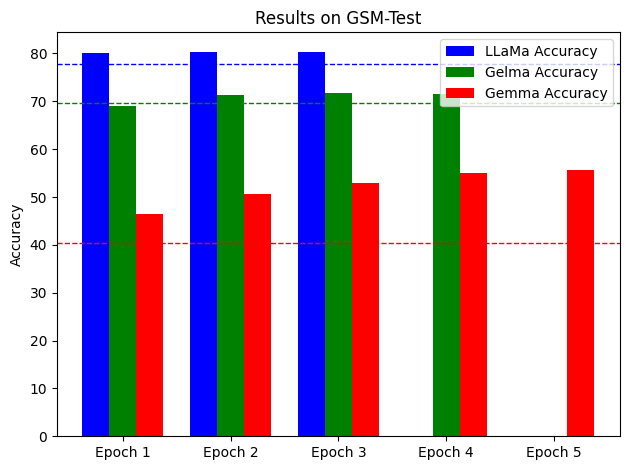

In [20]:
x = np.array([2,4,6,8,10])

bar_width = 0.5
x_llama = x - bar_width  # Shift apples to the left
x_gelma = x  # Center bananas
x_gemma = x + bar_width  # Shift cherries to the right

llama_acc = [80.2,80.4,80.4,0,0]
gelma_acc = [69.1,71.3,71.8,71.5,0]
gemma_acc = [46.5,50.6,52.9,55,55.6]

plt.bar(x_llama, llama_acc, width=bar_width, color='b',align='center', label='LLaMa Accuracy')
plt.bar(x_gelma, gelma_acc, width=bar_width, color='g',align='center', label='Gelma Accuracy')
plt.bar(x_gemma, gemma_acc, width=bar_width, color='r',align='center', label='Gemma Accuracy')

# Step 3: Add horizontal lines for each fruit
plt.axhline(y=77.9, linestyle='--', color='b',linewidth=1)
plt.axhline(y=69.7, linestyle='--', color='g',linewidth=1)
plt.axhline(y=40.4, linestyle='--', color='r',linewidth=1)

# Step 4: Customize the plot
plt.title('Results on GSM-Test')
# plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(ticks=x, labels=['Epoch 1', 'Epoch 2', 'Epoch 3', 'Epoch 4', 'Epoch 5'])
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [6]:
df_mm_all = pd.read_csv('../../inference/results/llama/results-all-mm.csv')
df_mm_cot = pd.read_csv('../../inference/results/llama/llama-mm-cot.csv')
df_mm_sub = pd.read_csv('../../inference/results/llama/llama-mm-sub.csv')
df_mm_pot = pd.read_csv('../../inference/results/llama/llama-mm-pot.csv')
df_gsm_test_all = pd.read_csv('../../inference/results/llama/results-all-test.csv')
df_gsm_train_all = pd.read_csv('../../inference/results/llama/results-all-train.csv')
df_svamp_all = pd.read_csv('../../inference/results/llama/results-all-svamp.csv')
df_asdiv_all = pd.read_csv('../../inference/results/llama/results-all-asdiv.csv')
# df_gsm_train_cot = pd.read_csv('../../inference/results/llama/llama-gsm-train-cot.csv')
# df_gsm_train_sub = pd.read_csv('../../inference/results/llama/llama-gsm-train-sub.csv')
# df_gsm_train_pot = pd.read_csv('../../inference/results/llama/llama-gsm-train-pot.csv')

In [3]:
df_mm_all['question'] = df_mm_all['question'].apply(lambda x: x[:-1])
df_gsm_test_all['question'] = df_gsm_test_all['question'].apply(lambda x: x[:-1])
# df_gsm_train_all['question'] = df_gsm_train_all['question'].apply(lambda x: x[:-1])

In [4]:
count_cot = 0
count_sub = 0
count_pot = 0
cot_correct = df_mm_all['cot-correct']
sub_correct = df_mm_all['sub-correct']
pot_correct = df_mm_all['pot-correct']
for i in range(len(df_mm_all)):
    if cot_correct[i] and not sub_correct[i] and not pot_correct[i]:
        count_cot += 1
    if not cot_correct[i] and sub_correct[i] and not pot_correct[i]:
        count_sub += 1
    if not cot_correct[i] and not sub_correct[i] and pot_correct[i]:
        count_pot += 1
print(count_cot)
print(count_sub)
print(count_pot)

9522
2804
5364


In [6]:
print(df_mm_all['cot-correct'].mean())
print(df_mm_all['sub-correct'].mean())
print(df_mm_all['pot-correct'].mean())
print(df_mm_all['correct'].mean())

0.8302461711169914
0.6734824793520968
0.7122034230525931
0.9350849526456936


In [12]:
112239 * (3 - 0.8302461711169914 - 0.6734824793520968 -0.7122034230525931 + 0.9350849526456936)

192956.0

In [12]:
with open('/cluster/project/sachan/liuron/Thesis/experiments/SVAMP.json','r') as json_file:
    dataset_svamp = json.load(json_file)
dataset_gsm = load_dataset('gsm8k','main')['test']
dataset_asdiv = ET.parse('/cluster/project/sachan/liuron/Thesis/experiments/ASDiv.xml')

In [13]:
def xml_to_dict(element):
    # If the element has no children, return its text content
    if len(element) == 0:
        return element.text

    # Otherwise, create a dictionary for the element
    result = {}
    for child in element:
        child_result = xml_to_dict(child)
        if child.tag not in result:
            result[child.tag] = child_result
        else:
            # If the tag already exists, make it a list of results
            if not isinstance(result[child.tag], list):
                result[child.tag] = [result[child.tag]]
            result[child.tag].append(child_result)
    
    # Include element attributes if they exist
    if element.attrib:
        result['@attributes'] = element.attrib

    return result

# Convert the root element to a dictionary
root = dataset_asdiv.getroot()
xml_dict = {root.tag: xml_to_dict(root)}
dataset_asdiv = xml_dict['Machine-Reading-Corpus-File']['ProblemSet']['Problem']

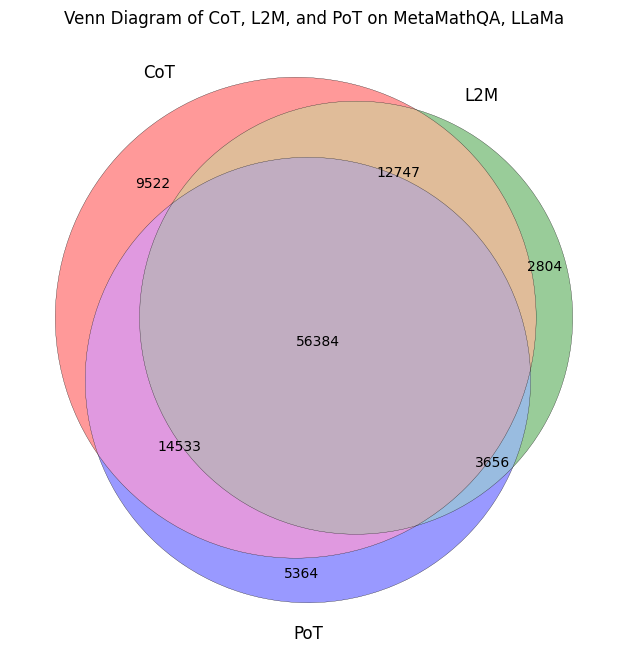

In [5]:
def plot_venn_diagram(cot,sub,pot,dataset,model):
    cot = set([index for index, value in enumerate(cot) if value])
    sub = set([index for index, value in enumerate(sub) if value])
    pot = set([index for index, value in enumerate(pot) if value])

    only_cot = len(cot - sub - pot)
    only_sub = len(sub - cot - pot)
    only_pot = len(pot - sub - cot)

    cot_sub = len(cot & sub - pot)
    cot_pot = len(cot & pot - sub)
    pot_sub = len(pot & sub - cot)
    
    cot_sub_pot = len(cot & sub & pot)
    
    plt.figure(figsize=(8, 8))
    v=venn3(subsets=(only_cot,only_sub,cot_sub,only_pot,cot_pot,pot_sub,cot_sub_pot),set_labels=('CoT','L2M','PoT'))
    c=venn3_circles(subsets=(only_cot,only_sub,cot_sub,only_pot,cot_pot,pot_sub,cot_sub_pot),linewidth=0.2)

    plt.title(f"Venn Diagram of CoT, L2M, and PoT on {dataset}, {model}")
    plt.show()

plot_venn_diagram(df_mm_all['cot-correct'],df_mm_all['sub-correct'],df_mm_all['pot-correct'],'MetaMathQA','LLaMa')

In [4]:
example_prompt_1_hint = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

Instruction:
Solve the following Math Word Problem using the given strategy.

Input:
Question: {}
Given strategy: {}

Response:
{}"""

example_prompt_1 = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

Instruction:
Solve the following Math Word Problem by firstly generating a strategy, then solving the problem according to the generated strategy.

Input:
Question: {}
<incorrect>None

Response:
<correct>{}: {}"""

example_prompt_2 = """Input:
Question: {}
<incorrect>{}

Response:
{}: {}"""

In [7]:
strategy_correct_map = {
    # 'Answer Only': df_mm_all['ao-correct'],
    'Chain of Thought': df_mm_all['cot-correct'],
    'Sub-questioning': df_mm_all['sub-correct'],
    'Program of Thought': df_mm_all['pot-correct'],
    'Unsolvable': ~df_mm_all['correct']
}

strategy_output_map = {
    # 'Answer Only': df_mm_ao,
    'Chain of Thought': df_mm_cot,
    'Sub-questioning': df_mm_sub,
    'Program of Thought': df_mm_pot
}

def create_text_2step(df_all):
    result1 = []
    result2 = []
    questions = df_all['question']

    for i in range(len(df_all)):
        for strategy1 in ['Chain of Thought','Sub-questioning','Program of Thought']:
            chain1 = strategy_output_map[strategy1]['output_answer'][i] + '<eos>' if strategy1 != 'Unsolvable' else '<eos>'
            if strategy_correct_map[strategy1][i]:
                text1 = example_prompt_1.format(questions[i],strategy1,chain1)
                result1.append(text1)
            else:
                # chain1 = chain1.replace('<eos>','')
                for strategy2 in ['Chain of Thought','Sub-questioning','Program of Thought']:
                    if strategy_correct_map[strategy2][i]:
                        chain2 = strategy_output_map[strategy2]['output_answer'][i] + '<eos>' if strategy2 != 'Unsolvable' else '<eos>'
                        text2 = example_prompt_2.format(questions[i],strategy1,strategy2,chain2)
                        # text2 = example_prompt_2.format(questions[i],strategy2,chain2)
                        result2.append(text2)
    # print(result2[0])
    return result1, result2

def create_text_hint(df_all):
    result1 = []
    questions = df_all['question']

    for i in range(len(df_all)):
        # if not (strategy_correct_map['Chain of Thought'][i] and strategy_correct_map['Sub-questioning'][i] and strategy_correct_map['Program of Thought'][i]):
        for strategy1 in ['Chain of Thought','Sub-questioning','Program of Thought']:
            chain1 = strategy_output_map[strategy1]['output_answer'][i] + '<eos>'
            if strategy_correct_map[strategy1][i]:
                # text1 = example_prompt_1.format(questions[i],strategy1,chain)
                text1 = example_prompt_1_hint.format(questions[i],strategy1,chain1)
                # text2 = example_prompt_2_contexted.format(questions[i],strategy1,chain1,strategy1,chain1)
                result1.append(text1)
    return result1

def split_data(texts,sample_ratio=0.8):
    random.shuffle(texts) 
    train_size = int(len(texts) * sample_ratio)
    sampled_questions = texts[:train_size]
    unsampled_questions = texts[train_size:]
    return sampled_questions, unsampled_questions
    

In [9]:
def prepare_data_hint(df):
    texts = create_text_hint(df)
    print(len(texts))
    train,val = split_data(texts,sample_ratio=0.9)
    print(len(val),len(train))
    for i in range(10):
        print(train[i])
    dict_train = {
        'text' : train
    }
    dict_val = {
        'text' : val
    }

    with open('data/train.json', "w") as json_file:
        json.dump(dict_train, json_file)
    with open('data/val.json', "w") as json_file:
        json.dump(dict_val, json_file)
        
def prepare_data_2step(df):
    texts1,texts2 = create_text_2step(df)
    print(len(texts1),len(texts2))
    train,val = split_data(texts1+texts2,sample_ratio=0.9)
    print(len(val),len(train))
    # for i in range(10):
    #     print(train[i])
    dict_train = {
        'text' : train
    }
    dict_val = {
        'text' : val
    }

    with open('data/train.json', "w") as json_file:
        json.dump(dict_train, json_file)
    with open('data/val.json', "w") as json_file:
        json.dump(dict_val, json_file)

def prepare_data_2step_separate(df):
    texts1,texts2 = create_text_2step(df)
    print(len(texts1),len(texts2))
    train1,val1 = split_data(texts1,sample_ratio=0.9)
    train2,val2 = split_data(texts2,sample_ratio=0.9)
    # print(len(train1),len(train2))
    for i in range(5):
        print(train1[i])
        print(train2[i])
    dict_train_step1 = {
        'text' : train1
    }
    dict_val_step1 = {
        'text' : val1
    }

    dict_train_step2 = {
        'text' : train2
    }
    dict_val_step2 = {
        'text' : val2
    }
    

    with open('data/train_step1.json', "w") as json_file:
        json.dump(dict_train_step1, json_file)
    with open('data/val_step1.json', "w") as json_file:
        json.dump(dict_val_step1, json_file)
    with open('data/train_step2.json', "w") as json_file:
        json.dump(dict_train_step2, json_file)
    with open('data/val_step2.json', "w") as json_file:
        json.dump(dict_val_step2, json_file)


In [10]:
prepare_data_2step(df_mm_all)
# prepare_data_2step_separate(df_mm_all)
# prepare_data_hint(df_mm_all)

248714 97252
34597 311369


In [14]:
example_prompt = """Input:
Question: {}
<incorrect>None

Response:
<correct>"""

example_prompt_cot = """Input:
Question: {}
<incorrect>Sub-questioning
<incorrect>Program of Thought

Response:
<correct>"""

example_prompt_sub = """Input:
Question: {}
<incorrect>Chain of Thought

Response:
<correct>"""

example_prompt_pot = """Input:
Question: {}
<incorrect>None

Response:
<correct>"""

strategies = []
for i in range(len(df_gsm_test_all)):
    temp = []
    if df_gsm_test_all['cot-correct'][i]:
        temp.append('Chain of Thought')
    elif df_gsm_test_all['pot-correct'][i]:
        temp.append('Program of Thought')
    elif df_gsm_test_all['sub-correct'][i]:
        temp.append('Sub-questioning')
    if len(temp) >= 1:
        strategies.append(random.sample(temp,1)[0])
    else:
        strategies.append('Chain of Thought')

def create_testset_gsm(df):
    questions = df['question']
    # test_data = [example_prompt.format(x) for x in df_gsm_test_all['question']]
    test_data = []
    for i in range(len(df)):
        # test_data.append(example_prompt_hint.format(strategies[i],questions[i]))
        test_data.append(example_prompt.format(questions[i]))
    print(test_data[0])
    test_dict = {
        'text': test_data,
        'correct-answer': list(df['correct-answer']),
        'correct': list(df['correct'])
    }
    with open('../epoch2/data/test.json', "w") as json_file:
        json.dump(test_dict, json_file)

def create_test_data(data,name):
    if name == 'gsm':
        questions = data['question']
        answers = [extract_pred(data['answer'][i]) for i in range(len(data['answer']))]
    if name == 'svamp':
        questions = [x['Body'] + x['Question'] for x in data]
        answers = [x['Answer'] for x in data]
    if name == 'asdiv':
        questions = [x['Body'] + '' + x['Question'] for x in data]
        answers = [x['Answer'].split(' ')[0] for x in data]
        filtered_questions = []
        filtered_answers = []
        for i in range(len(answers)):
            try:
                ans = float(answers[i])
                filtered_questions.append(questions[i])
                filtered_answers.append(answers[i])
            except:
                continue
        questions = filtered_questions
        answers = filtered_answers
    texts = [example_prompt.format(questions[i],'') for i in range(len(questions))]
    for i in range(5):
        print(texts[i])
        print()
    dict_test = {'text':texts,
                'correct-answer':answers,
                'correct':list(df_mm_all['correct'])}
    with open(f'../epoch2/data/test_{name}.json', "w") as json_file:
        json.dump(dict_test, json_file)
        
create_test_data(dataset_gsm,'gsm')
create_test_data(dataset_svamp,'svamp')
create_test_data(dataset_asdiv,'asdiv')

Input:
Question: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?
<incorrect>None

Response:
<correct>

Input:
Question: A robe takes 2 bolts of blue fiber and half that much white fiber.  How many bolts in total does it take?
<incorrect>None

Response:
<correct>

Input:
Question: Josh decides to try flipping a house.  He buys a house for $80,000 and then puts in $50,000 in repairs.  This increased the value of the house by 150%.  How much profit did he make?
<incorrect>None

Response:
<correct>

Input:
Question: James decides to run 3 sprints 3 times a week.  He runs 60 meters each sprint.  How many total meters does he run a week?
<incorrect>None

Response:
<correct>

Input:
Question: Every day, Wendi feeds each of her chickens three cups of mixed chicken 